# Problem Formulation

### What is the input?





the input data is a graph that represent chemical compound 💊 

*   The atoms of the chemical compound representing nodes and bonds as edges
*   It is a bioassay task for anticancer activity prediction
*   this dataset is very unbalanced 😞





### What is the output?


The main output is the label of anticancer activity prediction task 🔥


*   the label represent if the chemical compound is positive against non-small cell lung cancer, or negative:
  - 1 for possitive
  - 0 for negative


### What data mining function is required?

As I understand from this part of the slide


```
Data Mining Functions
1. Generalization and Summarization
2. Association and Correlation
3. Classification & Prediction
4. Clustering
5. Outlier/Anomaly Analysis
6. Time and Ordering 
7. Structure and Network Analysis
```

The data mining in this problem requires Classification & Prediction After cleaning the data



### What could be the challenges?

The Challenges represented in:


*   Reading SDF format of the files that contain data
*   Dealing with graphs
*   Unbalanced data








### What is the impact?

The impact of using the raw data as it is, without cleaning and reprocessing, will result a model with low accuracy that doesn't learn well or a desired from the data in the traing stage


---

The real-life impact of building a model that solve this problem is represent in finding the appropriate chemical compound that could treat lung cancer patients by distinguish if the chemical compound is positive against non-small cell lung cancer, or negative 🔥🔥🔥

<br/>


Solving this problem could provide a solution for cancer patients 😍!



### What is an ideal solution?

the ideal solution is to clean and preprocess the data before working with it



> Some of the possible solutions are:



*   Dealing with unbalanced data by up-sampling it
*   Preprocess text data (that represent the atom name in the chemical compound) before dealing with them











### What is the experimental protocol used and how was it carried out? 

After loading the data and cleaning and preprocessing it, the experimental protocol used is spliting the training dataset into training_set and validation_set to fit the model using the new training_set and measure the perormance (AUROC) of the model using the validation_set and then make the prediction by using the original test dataset 🔥



### What preprocessing steps are used?


*   view the data and understand it
*   adjust the training data to ***up-sample*** the positive class samples
*   preprocess text data through:
  -   build vocabulary from training set using tokenizer
  -   apply pad_sequences() function 
*   apply prepare_single_batch for all samples in gen_batch

# Get Started (Importing packages & Loading the data)


## Import packages 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
from tqdm.notebook import tqdm
import os
import math
sns.set()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from time import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


In [2]:
from sklearn.utils import resample 
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam



In [3]:
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import GRU, LSTM, Bidirectional

In [4]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput
from tf2_gnn.layers.message_passing import GNN_Edge_MLP, GNN_FiLM

     |████████████████████████████████| 54 kB 1.3 MB/s 
     |████████████████████████████████| 73 kB 1.3 MB/s 
     |████████████████████████████████| 346 kB 5.4 MB/s 
     |████████████████████████████████| 134 kB 51.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.0 MB/s 
     |████████████████████████████████| 462 kB 62.8 MB/s 
     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 178 kB 26.1 MB/s 
     |████████████████████████████████| 3.6 MB 44.3 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 41 kB 272 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# some seeting for pandas and hvplot

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

## Load Data

In [7]:
# create function that read sdf files

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                

In [ ]:
# Loading the data from csv files

train = read_sdf('data/train.sdf')
test = read_sdf('data/test_x.sdf')


In [9]:
# Look at first records of the data 
print(train[0])

(['S', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  8],
       [ 0, 14],
       [ 1, 10],
       [ 2, 11],
       [ 3,  7],
       [ 4,  7],
       [ 5,  9],
       [ 5, 14],
       [ 6, 14],
       [ 6, 17],
       [ 7, 22],
       [ 8,  9],
       [ 8, 10],
       [ 9, 11],
       [10, 12],
       [11, 13],
       [12, 13],
       [12, 15],
       [13, 16],
       [15, 18],
       [16, 19],
       [17, 20],
       [17, 21],
       [18, 19],
       [20, 23],
       [21, 24],
       [22, 23],
       [22, 24]]), 0)


## Data Up-Sampling


In [19]:
np.unique(np.array(train)[:,2],return_counts=True)

(array([0, 1], dtype=object), array([23806,  1218]))

In [20]:
train_df = pd.DataFrame(train, columns=['node','edge','label']) # convert train into DataFrame

In [21]:
# print the count of 0,1 in the label column
print(train_df['label'].value_counts())

0    23806
1     1218
Name: label, dtype: int64


In [22]:
class_0 = train_df[train_df['label'] == 0] # get all data that belong to negative class (label = 0) 
class_1 = train_df[train_df['label'] == 1] # get all data that belong to possitive class (label = 1) 

class_1 = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)  # resample class_1
upsampled_data = pd.concat([class_1, class_0])  # get upsampled data

In [23]:
# print the count of 0,1 in the label column after data up-sampling
print(upsampled_data["label"].value_counts()) 

1    23806
0    23806
Name: label, dtype: int64


In [24]:
# convert upsampled_data from DataFram to an array 
data_upsampled = upsampled_data.to_numpy()

## Splitting Data

In [25]:
# split the train data
# training_set, validation_set = train_test_split(train, test_size=0.15)

# split the up-sampled data
training_set, validation_set = train_test_split(data_upsampled, test_size=0.15)

# Visualizing/Inspecting a Sample

In [13]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [14]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

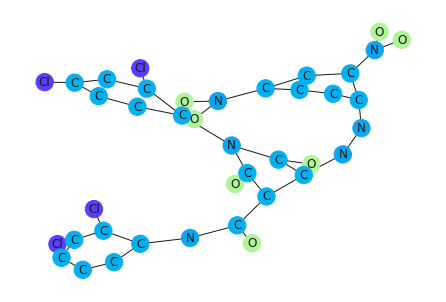

In [15]:
plt.clf()
visualize(training_set[0])

# Data Preprocessing


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



In [28]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [29]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 3 3 3 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0   7]
 [  1   9]
 [  2   5]
 [  2  11]
 [  3   8]
 [  3   9]
 [  4   5]
 [  4   6]
 [  4   9]
 [  5   7]
 [  6   8]
 [  6  12]
 [  7  10]
 [  8  14]
 [ 10  11]
 [ 10  15]
 [ 11  16]
 [ 12  13]
 [ 13  17]
 [ 13  18]
 [ 14  17]
 [ 15  19]
 [ 16  20]
 [ 18  21]
 [ 18  22]
 [ 19  20]
 [ 40  42]
 [ 41  46]
 [ 42  45]
 [ 42  46]
 [ 43  44]
 [ 43  45]
 [ 44  46]
 [ 45  47]
 [ 47  48]
 [ 48  49]
 [ 48  50]
 [ 49  51]
 [ 50  52]
 [ 51  53]
 [ 52  53]
 [ 80  96]
 [ 80  97]
 [ 81  96]
 [ 82 101]
 [ 82 109]
 [ 83 102]
 [ 83 109]
 [ 84 106]
 [ 84 116]
 [ 85 107]
 [ 85 117]
 [ 86 108]
 [ 87 115]
 [ 87 118]
 [ 88 115]
 [ 93  89]
 [ 89 105]
 [ 90  91]
 [ 90  92]
 [ 

# Saving Prediction Result


In [30]:
# define function to save the csv file of the result after each trial
def saveResult(y_pred, fileName):
  submission = pd.DataFrame({'label': y_pred})
  submission.index.name = 'id'
  
  submission.to_csv(fileName)

# Building Learning models

## Frist trial

thoughts and observations for trial 0, plan for trial 1: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this **Graph Neural Network** with the data that consider very unbalanced **without apply the Up-Sampling** on it

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading first the **defualt hyperparameters of GNN** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that unbalanced data affect the model accuracy and produce a low results 



### Building the model

In [16]:
data = keras.Input(batch_shape=(None,)) #Input layer for nodes (tokenized text data) 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32

# Graph Neural Network layer with defined hyperparameters
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [17]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [18]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
1330/1330 [==============================] - 23s 15ms/step - loss: 0.2236 - auc: 0.5050 - val_loss: 0.1928 - val_auc: 0.6526
Epoch 2/10
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1939 - auc: 0.6393 - val_loss: 0.1865 - val_auc: 0.6753
Epoch 3/10
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1900 - auc: 0.6620 - val_loss: 0.1877 - val_auc: 0.6994
Epoch 4/10
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1889 - auc: 0.6780 - val_loss: 0.1829 - val_auc: 0.7132
Epoch 5/10
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1877 - auc: 0.6771 - val_loss: 0.1852 - val_auc: 0.7173
Epoch 6/10
1330/1330 [==============================] - 22s 17ms/step - loss: 0.1861 - auc: 0.6764 - val_loss: 0.2086 - val_auc: 0.7033
Epoch 7/10
1330/1330 [==============================] - 34s 26ms/step - loss: 0.1860 - auc: 0.6832 - val_loss: 0.1837 - val_auc: 0.7184
Epoch 8/10
1330/1330 [==========================

### Predition & Saving results

In [ ]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [ ]:
saveResult(y_pred, 'sample_submission_trial1.csv')

## Second trial

thoughts and observations for trial 1, plan for trial 2:

<br/>

In this trial I used **the previous model with same configuration after applying the Up-Sampling technique** to the training dataset which was very unbalanced (by up-sample the positive class samples), in order to compare the results before and after Up-Sampling the data

From the result, we can say that this model is fitting the data well and produce better result than applying the model on train data as it's (before Up-sampling)

Based on these results, all the following trials will use the Up-Sampled data as it produce better results


### Model Training



In [31]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 44s 17ms/step - loss: 0.6084 - auc: 0.7291 - val_loss: 0.5745 - val_auc: 0.7762
Epoch 2/10
2530/2530 [==============================] - 44s 17ms/step - loss: 0.5726 - auc: 0.7719 - val_loss: 0.5661 - val_auc: 0.7946
Epoch 3/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5590 - auc: 0.7870 - val_loss: 0.5501 - val_auc: 0.8054
Epoch 4/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5513 - auc: 0.7959 - val_loss: 0.5503 - val_auc: 0.8008
Epoch 5/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5432 - auc: 0.8036 - val_loss: 0.5384 - val_auc: 0.8136
Epoch 6/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5376 - auc: 0.8085 - val_loss: 0.5342 - val_auc: 0.8169
Epoch 7/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5331 - auc: 0.8129 - val_loss: 0.5175 - val_auc: 0.8270
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [32]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [33]:
saveResult(y_pred, 'sample_submission_trial2.csv')

## Third trial

thoughts and observations for trial 2, plan for trial 3: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this Graph Neural Network **with the Up-Sampled data**, in addition to applying one of the **GCN aggregation mechanisms** by tuning the message_passing mechanisms and **configure the message passing style to be GGNN**

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading the **defualt hyperparameters of GNN** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers, and **set `message_calculation_class` parameter to be GGNN**

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that the results is much better than using the model without applying GCN aggregation mechanisms



### Building the model

In [34]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be GGNN (Gated Graph Neural Networks)
params['message_calculation_class'] = 'GGNN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_6[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_1 (Embedding)        (None, 20)           10000       ['input_4[0][0]']          

In [35]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [36]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 90s 34ms/step - loss: 0.6197 - auc: 0.7093 - val_loss: 0.5731 - val_auc: 0.7677
Epoch 2/10
2530/2530 [==============================] - 75s 30ms/step - loss: 0.5696 - auc: 0.7694 - val_loss: 0.5404 - val_auc: 0.8078
Epoch 3/10
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5292 - auc: 0.8128 - val_loss: 0.4993 - val_auc: 0.8441
Epoch 4/10
2530/2530 [==============================] - 69s 27ms/step - loss: 0.4912 - auc: 0.8431 - val_loss: 0.4789 - val_auc: 0.8535
Epoch 5/10
2530/2530 [==============================] - 70s 28ms/step - loss: 0.4662 - auc: 0.8604 - val_loss: 0.4501 - val_auc: 0.8748
Epoch 6/10
2530/2530 [==============================] - 70s 28ms/step - loss: 0.4416 - auc: 0.8768 - val_loss: 0.4204 - val_auc: 0.8906
Epoch 7/10
2530/2530 [==============================] - 68s 27ms/step - loss: 0.4219 - auc: 0.8882 - val_loss: 0.4417 - val_auc: 0.8868
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [37]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [38]:
saveResult(y_pred, 'sample_submission_trial3.csv')

## Fourth trial

thoughts and observations for trial 3, plan for trial 4: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this Graph Neural Network **with the Up-Sampled data**, in addition to applying one of the **GCN aggregation mechanisms** by tuning the message_passing mechanisms and **configure the message passing style to be RGCN**

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading the **defualt hyperparameters of GNN** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers, and **set `message_calculation_class` parameter to be RGCN**

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that the results is much better than using the model without applying GCN aggregation mechanisms, but in this trail the result is lower than previous model whose message_calculation_class parameter equals to GGNN



### Building the model

In [39]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGCN (Relational Graph Convolutional Networks)
params['message_calculation_class'] = 'RGCN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the output layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 20)           10000       ['input_7[0][0]']          

In [40]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [41]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 51s 19ms/step - loss: 0.6265 - auc: 0.7048 - val_loss: 0.5988 - val_auc: 0.7436
Epoch 2/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5986 - auc: 0.7454 - val_loss: 0.5906 - val_auc: 0.7552
Epoch 3/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5888 - auc: 0.7579 - val_loss: 0.5723 - val_auc: 0.7810
Epoch 4/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5748 - auc: 0.7744 - val_loss: 0.5534 - val_auc: 0.7990
Epoch 5/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5634 - auc: 0.7855 - val_loss: 0.5528 - val_auc: 0.7988
Epoch 6/10
2530/2530 [==============================] - 42s 17ms/step - loss: 0.5521 - auc: 0.7973 - val_loss: 0.5274 - val_auc: 0.8187
Epoch 7/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5388 - auc: 0.8086 - val_loss: 0.5345 - val_auc: 0.8172
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [42]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [43]:
saveResult(y_pred, 'sample_submission_trial4.csv')

## Fifth trial

thoughts and observations for trial 4, plan for trial 5: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this Graph Neural Network **with the Up-Sampled data**, in addition to applying one of the **GCN aggregation mechanisms** by tuning the message_passing mechanisms and **configure the message passing style to be RGAT**

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading the **defualt hyperparameters of GNN** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers, and **set `message_calculation_class` parameter to be RGAT**, and set the number of parallel (independent) weighted sums that are computed **`num_heads` to be 4**

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that the results is much better than the previous trial which has message_calculation_class parameter equals to RGCN, but it is lower than the model whose message_calculation_class parameter equals to GGNN



### Building the model

In [44]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGAT (Relational Graph Attention Networks)
params['message_calculation_class'] = 'RGAT'
# configures the number of parallel (independent) weighted sums that are computed, whose results are concatenated to obtain the final result.
params["num_heads"] = 4

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 20)           10000       ['input_10[0][0]']         

In [45]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [46]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 65s 24ms/step - loss: 0.6232 - auc: 0.7103 - val_loss: 0.6078 - val_auc: 0.7435
Epoch 2/10
2530/2530 [==============================] - 59s 23ms/step - loss: 0.5844 - auc: 0.7595 - val_loss: 0.5664 - val_auc: 0.7830
Epoch 3/10
2530/2530 [==============================] - 59s 23ms/step - loss: 0.5624 - auc: 0.7836 - val_loss: 0.5463 - val_auc: 0.8004
Epoch 4/10
2530/2530 [==============================] - 59s 23ms/step - loss: 0.5464 - auc: 0.7999 - val_loss: 0.5282 - val_auc: 0.8180
Epoch 5/10
2530/2530 [==============================] - 59s 23ms/step - loss: 0.5347 - auc: 0.8092 - val_loss: 0.5205 - val_auc: 0.8308
Epoch 6/10
2530/2530 [==============================] - 60s 24ms/step - loss: 0.5198 - auc: 0.8227 - val_loss: 0.5172 - val_auc: 0.8342
Epoch 7/10
2530/2530 [==============================] - 60s 24ms/step - loss: 0.5082 - auc: 0.8322 - val_loss: 0.4872 - val_auc: 0.8499
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [47]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [48]:
saveResult(y_pred, 'sample_submission_trial5.csv')

## Sixth trial

thoughts and observations for trial 5, plan for trial 6: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this Graph Neural Network **with the Up-Sampled data**, in addition to applying one of the **GCN aggregation mechanisms** by tuning the message_passing mechanisms and **configure the message passing style to be RGIN**

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading the **defualt hyperparameters of GNN** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers, and **set `message_calculation_class` parameter to be RGIN**, and set the **`num_aggr_MLP_hidden_layers` to be 2** as it is required parameter for RGIN

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that the results is much better than the previous trial which has message_calculation_class parameter equals to RGCN, but it is lower than the model whose message_calculation_class parameter equals to GGNN



### Building the model

In [49]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGIN (Relational Graph Isomorphism Networks)
params['message_calculation_class'] = 'RGIN'
params['num_aggr_MLP_hidden_layers'] = 2

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_4 (Embedding)        (None, 20)           10000       ['input_13[0][0]']         

In [50]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [51]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 56s 21ms/step - loss: 0.6270 - auc: 0.7064 - val_loss: 0.6064 - val_auc: 0.7336
Epoch 2/10
2530/2530 [==============================] - 53s 21ms/step - loss: 0.6035 - auc: 0.7394 - val_loss: 0.5844 - val_auc: 0.7624
Epoch 3/10
2530/2530 [==============================] - 57s 23ms/step - loss: 0.5869 - auc: 0.7606 - val_loss: 0.5846 - val_auc: 0.7821
Epoch 4/10
2530/2530 [==============================] - 53s 21ms/step - loss: 0.5655 - auc: 0.7830 - val_loss: 0.5585 - val_auc: 0.7899
Epoch 5/10
2530/2530 [==============================] - 53s 21ms/step - loss: 0.5545 - auc: 0.7929 - val_loss: 0.5488 - val_auc: 0.8125
Epoch 6/10
2530/2530 [==============================] - 53s 21ms/step - loss: 0.5421 - auc: 0.8052 - val_loss: 0.5480 - val_auc: 0.8022
Epoch 7/10
2530/2530 [==============================] - 54s 21ms/step - loss: 0.5335 - auc: 0.8131 - val_loss: 0.5089 - val_auc: 0.8320
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [52]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [53]:
saveResult(y_pred, 'sample_submission_trial6.csv')

## Seventh trial

thoughts and observations for trial 6, plan for trial 7: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this Graph Neural Network **with the Up-Sampled data**, in addition to applying one of the **GCN aggregation mechanisms** by tuning the message_passing mechanisms and **configure the message passing style to be GNN_Edge_MLP**

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading the **defualt hyperparameters of GNN_Edge_MLP** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers, and **configure all the parameters that needed by GNN_Edge_MLP**

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that the result is lower than the model whose message_calculation_class parameter equals to GGNN, but it is better than other trials



### Building the model

In [54]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters of GNN_Edge_MLP
params = GNN_Edge_MLP.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the parameters that needed by GNN_Edge_MLP
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'gru'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.2

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_5 (Embedding)        (None, 20)           10000       ['input_16[0][0]']         

In [55]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [56]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 53s 20ms/step - loss: 0.6126 - auc: 0.7230 - val_loss: 0.5722 - val_auc: 0.7751
Epoch 2/10
2530/2530 [==============================] - 50s 20ms/step - loss: 0.5707 - auc: 0.7758 - val_loss: 0.5486 - val_auc: 0.8116
Epoch 3/10
2530/2530 [==============================] - 50s 20ms/step - loss: 0.5499 - auc: 0.8014 - val_loss: 0.5253 - val_auc: 0.8219
Epoch 4/10
2530/2530 [==============================] - 49s 19ms/step - loss: 0.5336 - auc: 0.8152 - val_loss: 0.5292 - val_auc: 0.8312
Epoch 5/10
2530/2530 [==============================] - 48s 19ms/step - loss: 0.5202 - auc: 0.8277 - val_loss: 0.5072 - val_auc: 0.8438
Epoch 6/10
2530/2530 [==============================] - 48s 19ms/step - loss: 0.5112 - auc: 0.8351 - val_loss: 0.4875 - val_auc: 0.8541
Epoch 7/10
2530/2530 [==============================] - 48s 19ms/step - loss: 0.4998 - auc: 0.8437 - val_loss: 0.4818 - val_auc: 0.8544
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [57]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [58]:
saveResult(y_pred, 'sample_submission_trial7.csv')

## Eighth trial

thoughts and observations for trial 7, plan for trial 8: 

<br/>

I used **Graph Neural Network** as this task is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph.

I used this Graph Neural Network **with the Up-Sampled data**, in addition to applying one of the **GCN aggregation mechanisms** by tuning the message_passing mechanisms and **configure the message passing style to be GNN_FiLM**

After declaring the GNNInput, I defined the hyperparameters for GNN layer by loading the **defualt hyperparameters of GNN_FiLM** and set **`hidden_dim` to be 32** which represent the size of the output of all message passing layers, and **configure all the parameters that needed by GNN_FiLM**

then adding Graph Neural Network layer with the defined hyperparameters and calculating segmented mean based on segment_ids

Finally, define the output layer of the model then building and compiling the model using **BinaryCrossentropy** for loss and the **AUC metric** to measure the performance of the network.

<br/>

While fitting the model I specified the value of batch size to be 16 and the value of epochs to be 10 and used the `validation_set` to validate our model

<br/>

From the result, we can say that the result of this trial is mush lower than other models that applying the GCN aggregation mechanisms



### Building the model

In [59]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters of GNN_FiLM
params = GNN_FiLM.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the parameters that needed by GNN_FiLM
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'gru'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.2

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_6 (TFOpLamb  ()                  0           ['input_21[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_6 (Embedding)        (None, 20)           10000       ['input_19[0][0]']         

In [60]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [61]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 46s 17ms/step - loss: 0.6344 - auc: 0.6929 - val_loss: 0.6153 - val_auc: 0.7222
Epoch 2/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.6107 - auc: 0.7294 - val_loss: 0.6097 - val_auc: 0.7593
Epoch 3/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5949 - auc: 0.7497 - val_loss: 0.5935 - val_auc: 0.7674
Epoch 4/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5799 - auc: 0.7658 - val_loss: 0.5705 - val_auc: 0.7865
Epoch 5/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5710 - auc: 0.7779 - val_loss: 0.5553 - val_auc: 0.7973
Epoch 6/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5629 - auc: 0.7859 - val_loss: 0.5450 - val_auc: 0.8082
Epoch 7/10
2530/2530 [==============================] - 43s 17ms/step - loss: 0.5558 - auc: 0.7939 - val_loss: 0.5375 - val_auc: 0.8101
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [62]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [63]:
saveResult(y_pred, 'sample_submission_trial8.csv')

## As the previous trails cover all possible GCN aggregation mechanisms (aka message_passing mechanisms) used in the graph convolution layer represented in Graph Neural Networks documentation: https://github.com/microsoft/tf2-gnn

## And out of all trials the best two trails that give the highest accuracy are : Trial_3 & Trial_7

## The following and last two trials will take these best models and adjust thier hyperparamters to achieve better accuracy 

## Ninth trial

thoughts and observations for trial 8, plan for trial 9:

<br/>

In this trial I used **the same model that used in the Third trial** which is **Graph Neural Network with message_passing mechanisms equals to GGNN**
after changing its hyperparameter by setting `hidden_dim` to be 16 instead of 32 and test the model and found that it decreased the accuracy, so I **changed the `hidden_dim` agian to be 64**and this help in improving the model result


From the result, we can say that tuning hyperparameters produce better results



### Building the model

In [67]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the message passing style to be GGNN (Gated Graph Neural Networks)
params['message_calculation_class'] = 'GGNN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_8 (TFOpLamb  ()                  0           ['input_27[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_8 (Embedding)        (None, 20)           10000       ['input_25[0][0]']         

In [68]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [69]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 151s 58ms/step - loss: 0.6035 - auc: 0.7365 - val_loss: 0.5916 - val_auc: 0.7691
Epoch 2/10
2530/2530 [==============================] - 145s 57ms/step - loss: 0.5452 - auc: 0.7990 - val_loss: 0.5173 - val_auc: 0.8289
Epoch 3/10
2530/2530 [==============================] - 149s 59ms/step - loss: 0.5089 - auc: 0.8299 - val_loss: 0.5032 - val_auc: 0.8467
Epoch 4/10
2530/2530 [==============================] - 145s 57ms/step - loss: 0.4788 - auc: 0.8524 - val_loss: 0.4730 - val_auc: 0.8569
Epoch 5/10
2530/2530 [==============================] - 146s 58ms/step - loss: 0.4516 - auc: 0.8705 - val_loss: 0.4135 - val_auc: 0.8937
Epoch 6/10
2530/2530 [==============================] - 151s 60ms/step - loss: 0.4193 - auc: 0.8899 - val_loss: 0.4127 - val_auc: 0.8958
Epoch 7/10
2530/2530 [==============================] - 147s 58ms/step - loss: 0.3912 - auc: 0.9048 - val_loss: 0.3934 - val_auc: 0.9069
Epoch 8/10
2530/2530 [===================

### Predition & Saving results

In [70]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [71]:
saveResult(y_pred, 'sample_submission_trial9.csv')

## Tenth trial

thoughts and observations for trial 9, plan for trial 10:

<br/>

In this trial I used **the same model that used in the Seventh trial** which is **Graph Neural Network with message_passing mechanisms equals to GNN_Edge_MLP**
after changing its hyperparameter by setting `hidden_dim` to be 64 instead of 32 and set `global_exchange_mode` to be 'mlp'instead of 'gru', also set `layer_input_dropout_rate` to be 0.1 instead of 0.2and found that this help in improving the model result


From the result, we can say that tuning hyperparameters produce better results



### Building the model

In [72]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters of GNN_Edge_MLP
params = GNN_Edge_MLP.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the parameters that needed by GNN_Edge_MLP
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'mlp'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.1

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_9 (TFOpLamb  ()                  0           ['input_30[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_9 (Embedding)        (None, 20)           10000       ['input_28[0][0]']         

In [73]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

### Model Training



In [74]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2530/2530 [==============================] - 93s 36ms/step - loss: 0.5797 - auc: 0.7673 - val_loss: 0.5353 - val_auc: 0.8168
Epoch 2/10
2530/2530 [==============================] - 89s 35ms/step - loss: 0.5276 - auc: 0.8218 - val_loss: 0.4945 - val_auc: 0.8495
Epoch 3/10
2530/2530 [==============================] - 89s 35ms/step - loss: 0.4993 - auc: 0.8458 - val_loss: 0.4754 - val_auc: 0.8664
Epoch 4/10
2530/2530 [==============================] - 89s 35ms/step - loss: 0.4757 - auc: 0.8625 - val_loss: 0.4547 - val_auc: 0.8733
Epoch 5/10
2530/2530 [==============================] - 89s 35ms/step - loss: 0.4543 - auc: 0.8756 - val_loss: 0.4413 - val_auc: 0.8868
Epoch 6/10
2530/2530 [==============================] - 90s 35ms/step - loss: 0.4378 - auc: 0.8855 - val_loss: 0.4189 - val_auc: 0.8979
Epoch 7/10
2530/2530 [==============================] - 89s 35ms/step - loss: 0.4262 - auc: 0.8916 - val_loss: 0.4095 - val_auc: 0.9031
Epoch 8/10
2530/2530 [==========================

### Predition & Saving results

In [75]:
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


In [78]:
saveResult(y_pred, 'sample_submission_trial10.csv')

# Questions

## 🌈 Based on the provided template, describe the format of the input file (sdf file)


One of the most widely used industry standards are chemical table file formats, like the Structure Data Format (SDF) files. They are text files that adhere to a strict format for representing multiple chemical structure records and associated data fields. --Wikipedia

<br/>


---

<br/>

The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections. Different molecules are delimited by &dollar;&dollar;&dollar;&dollar; expression.

Each sample starts with header which tells about the name/title of the compound. Other sections includes information about Atom count, version number, connections etc. Atom block tells about the elements of the compound. Bond/Edge block tells about the bonding structure of the compound. These both blocks are used to get information about the compound and saving them in form of edges and nodes. Each node is the atom given in the chemical molecule.



## 🌈 What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

The input tensors in this network are:

- **data:** The data contains the nodes of the chemical compound in the tokenized form. Nodes for each compound are extracted, then they are tokenized using the tokenizer and finally padding is done using pad_sequence method. The shape for each batch is **[batch_size*max_len_nodes]**, where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.

- **edge:** edge is the input tensor which carries information about connections between atoms. The shape of edge is **[sum_of_all_edges,2]**. The sum_of_all_edges represents the sum(no. of edges of each sample) of the batch_size. For example in a batch of 3 samples, the number of edges in sample 1: 21, sample 2: 20 and sample 3: 40. So the size of edge tensor would be [81,2].

- **node2graph:** It is the input tensor which is used for segmented mean and contains information about segmented ids. The shape for each batch is **[batch_size*max_len_nodes]**, where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.

## 🌈 For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

**gnn_out:** 

The gnn_out is of shape [batch_size_node_dimension,hidden layers], where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It represents the aggregation output of the model for each hidden layer.


<br/>

---
<br/>

**avg:**

Average takes the segmented mean of the gnn_out based on the segmented ids. For each sample in the batch_size, the output of gnn_out is [tokenized_vector_dimension, hidden_layers]. Each sample has one segment id. Thus the segment_mean takes the mean of all the output data in the gnn_out output and represents one sample with one number for each hidden layer. The final output of the avg tensor is of shape [batch_size, hidden_layer]. It is a way of collecting information for each sample and representing it in the form of mean data.

## 🌈 What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?


**segment_mean:** takes the mean of the data which have same segmented ids.

**reduce_mean:** computes the mean of elements across dimensions of a tensor given the arguments.

<br/>


---

<br/>

**pred:** The final output (pred) tells about the probability of a chemical compound to be active for the cancer cell or not. The shape of pred is [batch_size,1]. Thus for each sample, the final output is a number which represents the probability associated with each chemical compound about its activity.



## 🌈 What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?


The template implements the default setting of the number of layers in the GCN network which is 4 as given in the documentaion. The default message passing method is RGCN (Relational Graph Convolutional Networks). Using multiple GCN helps in incorporating all the graph complexity properly and thus creates a better model.